## Primary Biliary Cirrhosis Survival Analysis

By Ronnie Nop

### Introduction
**Primary biliary cirrhosis (pbc)** is a chronic liver disease caused by bile buildup in the liver which results in progressive destruction of the small bile ducts leading to liver damage. There are currently no known treatments to cure pbc, however, there are many ways to slow down its progression through treatment, surgery, and support care. Depending on the severity, liver transplants can be considered as potentially life-saving.

### Survival Analysis
Survival analysis is used to analyze data in which time until the event is considered where the response is either event time or survival time. The purpose is to help answer patient questions and determine survival probabilities for individual patients at any time. One of the main goals of survival analysis is to help clinicians diagnose severely diseased patients to help decide the best appropriate treatments available to them to improve their survivability. In the case of pbc, a survival analysis such as this can help guide clinicians to timely select patients in severe need of liver transplants or recommend other types of treatment depending on their severity of the disease at the time.  

**Cox Proportional Hazards Model**

Traditional linear model used for survival analysis describing the hazard for an individual at time t. **Hazard** is defined as the probability of the disease event occurring. The idea behind Cox Proportional Hazards model is to take some baseline hazard $\lambda_0$ and incorporate individual features $e^{\theta^T X_i}$ with feature vector **X**. This allows us to compute the relative risks for each individual patient at time t.


$$
\lambda(t, x) = \lambda_0(t)e^{\theta^T X_i}
$$

**Random Survival Forests** 

Introducing machine learning methods to survival analysis has helped solve some issues with traditional survival models. Survival trees is advantageous in that it can model non-linear relationships. Cox Proportional Hazards model assumes the shape of the risk is the same in all patients, different only in the proportions. On the other hand, survival trees captures the non-linearities between patients where risk factor hazards can change and switch over time.  

**Performance Metric**

We will be using the Harrell's c-index to evaluate model performances. The c-index is a concordant statistic where the idea is that a patient with a shorter time to event (eg. faster time to death) should have a higher risk score than a patient with a longer time to event (eg. slower time to death). It is a generalization of the ROC-AUC to survival data.



In [1]:
import warnings
warnings.filterwarnings('ignore')

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index as cindex
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('pbc.csv')
df.sample(3)

,id,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
108,109,2504,0,2.0,44.062971,f,0.0,0.0,0.0,0.0,0.5,120.0,3.61,53.0,804.0,110.05,52.0,271.0,10.6,3.0
280,281,41,2,1.0,65.883641,f,1.0,0.0,0.0,1.0,17.9,175.0,2.10,220.0,705.0,338.00,229.0,62.0,12.9,4.0
399,400,1223,0,NaN,44.000000,f,NaN,NaN,NaN,0.0,0.5,NaN,3.34,NaN,NaN,NaN,NaN,258.0,10.6,2.0


#### Data Cleaning

In [3]:
df = df[df['status'] != 1]
df['status'] = df['status'] / 2.0 
df['time'] = df['time'] / 365.0
df['trt'] = df['trt'] - 1
df['sex'] = df['sex'].map({'f':0.0, 'm':1.0})
df = df.drop('id', axis=1)
df = df.dropna(axis=0)

In [4]:
df.sample(3)

,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
33,10.775342,0.0,0.0,52.060233,0.0,0.0,0.0,0.0,0.0,0.8,364.0,3.70,37.0,1840.0,170.50,64.0,273.0,10.5,2.0
111,9.438356,1.0,1.0,55.457906,0.0,0.0,1.0,1.0,0.0,2.0,267.0,3.67,89.0,754.0,196.85,90.0,136.0,11.8,4.0
107,7.076712,1.0,0.0,50.357290,0.0,0.0,0.0,0.0,0.0,0.4,127.0,3.50,14.0,1062.0,49.60,84.0,334.0,10.3,2.0


In [7]:
df.shape

(258, 19)

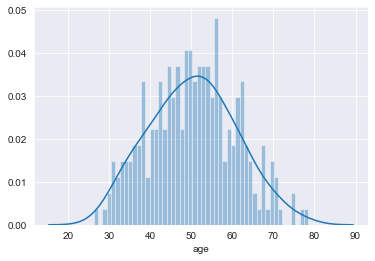

In [42]:
sns.distplot(df['age'], bins=50)
plt.show()

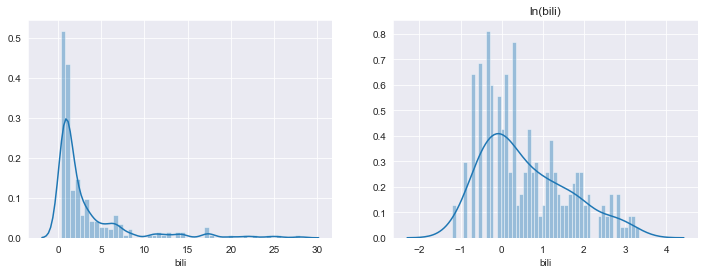

In [41]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sns.distplot(df['bili'], bins=50)
plt.subplot(1, 2, 2)
plt.title('ln(bili)')
sns.distplot(np.log(df['bili']), bins=50)
plt.show()

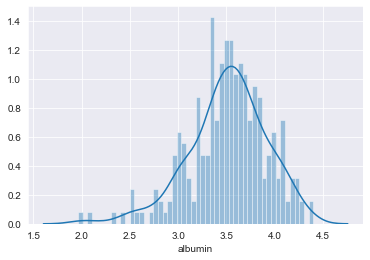

In [40]:
sns.distplot(df['albumin'], bins=50)
plt.show()

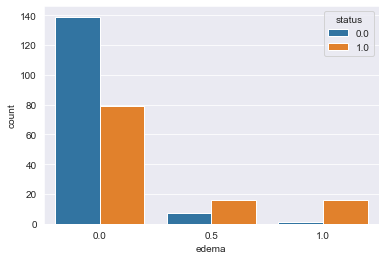

In [39]:
sns.countplot(df['edema'], hue=df['status'])
plt.show()

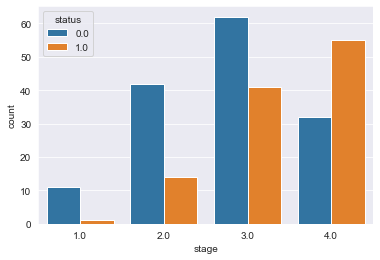

In [38]:
sns.countplot(df['stage'], hue=df['status'])
plt.show()

#### Train-Validation-Test Splits

In [103]:
np.random.seed(0)
df_dev, df_test = train_test_split(df, test_size = 0.25)
df_train, df_val = train_test_split(df_dev, test_size = 0.25)

#### Normalization

In [104]:
cont_columns = ['age', 'bili', 'chol', 'albumin', 'copper', 'alk.phos', 'ast', 'trig', 'platelet', 'protime']
mean = df_train.loc[:, cont_columns].mean()
std = df_train.loc[:, cont_columns].std()

In [105]:
df_train.loc[:, cont_columns] = (df_train.loc[:, cont_columns] - mean) / std
df_val.loc[:, cont_columns] = (df_val.loc[:, cont_columns] - mean) / std
df_test.loc[:, cont_columns] = (df_test.loc[:, cont_columns] - mean) / std

In [106]:
df_train.sample(3)

,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
31,12.391781,0.0,1.0,0.276095,0.0,0.0,1.0,0.0,0.0,-0.283662,-0.458084,-0.407096,0.141786,1.977557,-0.727484,0.489314,0.261306,-0.136767,4.0
58,6.093151,1.0,0.0,-0.961298,0.0,0.0,1.0,1.0,0.0,-0.480044,-0.115427,-0.016447,-0.602217,2.113269,0.136264,-0.041526,0.648539,-0.136767,3.0
51,6.536986,1.0,0.0,-0.038234,1.0,0.0,0.0,0.0,0.0,0.541140,1.342145,0.471866,0.957327,1.117057,1.711334,-0.525528,1.102155,-0.136767,1.0


#### Dummy Encode Categorical Variables
* edema {0.0, 0.5, 1.0}
* stage {1.0, 2.0, 3.0, 4.0}

In [107]:
onehot_df_train = pd.get_dummies(df_train, columns=['edema','stage'], drop_first=True)
onehot_df_val = pd.get_dummies(df_val, columns=['edema','stage'], drop_first=True)
onehot_df_test = pd.get_dummies(df_test, columns=['edema','stage'], drop_first=True)

In [108]:
onehot_df_train.sample(3)

,time,status,trt,age,sex,ascites,hepato,spiders,bili,chol,...,alk.phos,ast,trig,platelet,protime,edema_0.5,edema_1.0,stage_2.0,stage_3.0,stage_4.0
120,0.523288,1.0,1.0,1.541634,1.0,1.0,1.0,0.0,-0.381853,-1.025770,...,-0.441938,-1.437625,-1.212498,-0.546352,2.278591,0,1,0,0,1
60,11.660274,0.0,1.0,-0.642485,1.0,0.0,0.0,0.0,-0.519320,-0.693341,...,-0.642483,-1.162903,0.957703,-0.568480,2.092794,0,0,0,0,0
59,11.958904,0.0,0.0,0.675110,0.0,0.0,0.0,0.0,-0.460406,1.291002,...,-0.534558,-0.949231,-1.071981,-0.380395,-0.415462,0,0,0,1,0


In [109]:
onehot_df_train.columns

Index(['time', 'status', 'trt', 'age', 'sex', 'ascites', 'hepato', 'spiders',
       'bili', 'chol', 'albumin', 'copper', 'alk.phos', 'ast', 'trig',
       'platelet', 'protime', 'edema_0.5', 'edema_1.0', 'stage_2.0',
       'stage_3.0', 'stage_4.0'],
      dtype='object')

### Cox Proportional Hazards Model

In [110]:
cph = CoxPHFitter()
cph.fit(onehot_df_train, duration_col = 'time', event_col = 'status', step_size=0.1)

<lifelines.CoxPHFitter: fitted with 144 total observations, 82 right-censored observations>

In [111]:
cph.check_assumptions(onehot_df_train)

Proportional hazard assumption looks okay.


In [112]:
cph.print_summary()

In [113]:
cph.params_

trt         -0.137584
age          0.186090
sex          0.652674
ascites      1.999645
hepato       0.716418
spiders      0.463892
bili         0.401643
chol         0.278182
albumin     -0.360747
copper       0.429540
alk.phos    -0.181953
ast          0.057004
trig        -0.091867
platelet    -0.161953
protime     -0.004029
edema_0.5    0.446127
edema_1.0    0.221350
stage_2.0    0.670425
stage_3.0    1.064667
stage_4.0    0.795648
Name: coef, dtype: float64

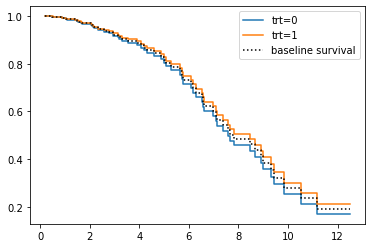

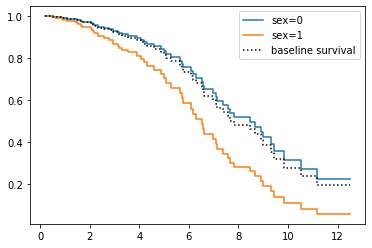

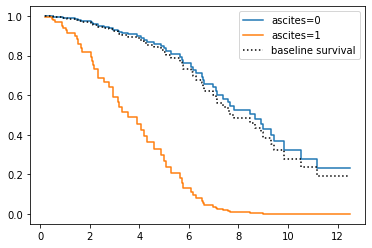

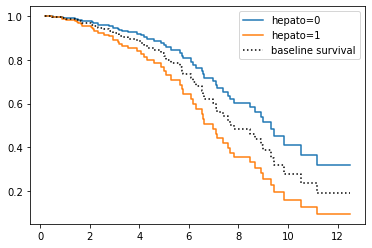

In [114]:
cph.plot_covariate_groups(['trt'], values=[0, 1])
cph.plot_covariate_groups('sex', values=[0, 1])
cph.plot_covariate_groups('ascites', values=[0, 1])
cph.plot_covariate_groups('hepato', values=[0, 1])
plt.show()

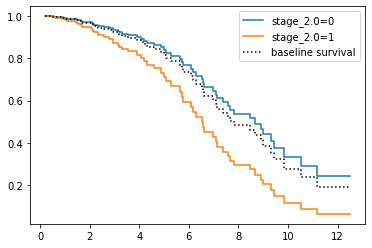

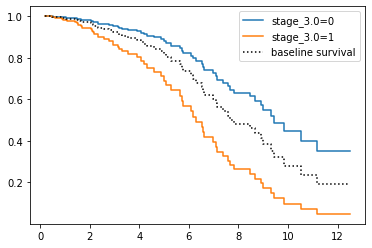

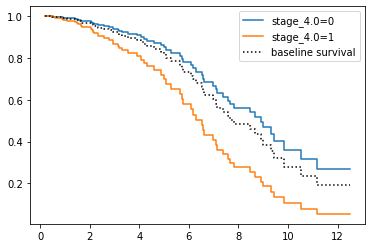

In [115]:
cph.plot_covariate_groups('stage_2.0', values=[0, 1])
cph.plot_covariate_groups('stage_3.0', values=[0, 1])
cph.plot_covariate_groups('stage_4.0', values=[0, 1])
plt.show()

In [116]:
print("Full CPH Model")
print("Training Score: ",cph.score(onehot_df_train, scoring_method="concordance_index"))
print("Validation Score: ", cph.score(onehot_df_val, scoring_method="concordance_index"))
print("Testing Score: ",cph.score(onehot_df_test, scoring_method="concordance_index"))

Full CPH Model
Training Score:  0.8387952263686305
Validation Score:  0.8061068702290076
Testing Score:  0.8607594936708861


### Mayo Clinic Model

Reference: http://hbiostat.org/papers/rms/datasetsCaseStudies/dic89pro.pdf

In [117]:
df = pd.read_csv('pbc.csv')
df = df[df['status'] != 1]
df['status'] = df['status'] / 2.0
df['time'] = df['time'] / 365.0
df['trt'] = df['trt'] - 1
df['sex'] = df['sex'].map({'f':0.0, 'm':1.0})
df = df.drop('id', axis=1)
df = df.dropna(axis=0)

In [118]:
np.random.seed(0)
mayo = df
columns = ['time','status','age','bili','protime','edema','albumin']
mayo = mayo[columns]
mayo['bili'] = np.log(mayo['bili'])
mayo['protime'] = np.log(mayo['protime'])
mayo['albumin'] = np.log(mayo['albumin'])
#mayo = pd.get_dummies(mayo, columns=['edema'], drop_first=True)

mayo_dev, mayo_test = train_test_split(mayo, test_size = 0.25)
mayo_train, mayo_val = train_test_split(mayo_dev, test_size = 0.25)

In [119]:
mayo.sample(3)

,time,status,age,bili,protime,edema,albumin
22,0.723288,1.0,55.967146,2.856470,2.459589,1.0,1.078410
199,6.350685,0.0,32.232717,1.547563,2.292535,0.0,1.266948
248,4.884932,0.0,47.980835,0.262364,2.360854,0.0,1.163151


In [120]:
mayo_cph = CoxPHFitter()
mayo_cph.fit(mayo_train, duration_col = 'time', event_col = 'status', step_size=0.1)

<lifelines.CoxPHFitter: fitted with 144 total observations, 82 right-censored observations>

In [121]:
mayo_cph.check_assumptions(mayo_train)

Proportional hazard assumption looks okay.


In [122]:
mayo_cph.print_summary()

In [123]:
mayo_cph.params_

age        0.020982
bili       0.792886
protime    1.836798
edema      0.742632
albumin   -2.814489
Name: coef, dtype: float64

In [124]:
print("Mayo Clinic Model")
print("Training Score: ",mayo_cph.score(mayo_train, scoring_method="concordance_index"))
print("Validation Score: ", mayo_cph.score(mayo_val, scoring_method="concordance_index"))
print("Testing Score: ",mayo_cph.score(mayo_test, scoring_method="concordance_index"))

Mayo Clinic Model
Training Score:  0.8026141314642925
Validation Score:  0.8549618320610687
Testing Score:  0.8742088607594937


### Random Survival Forests

In [125]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.svm import FastSurvivalSVM, FastKernelSurvivalSVM
from sksurv.util import Surv

In [126]:
df = pd.read_csv('pbc.csv')

df = df[df['status'] != 1]
df['status'] = df['status'] / 2.0
df['time'] = df['time'] / 365.0
df['trt'] = df['trt'] - 1
df['sex'] = df['sex'].map({'f':0.0, 'm':1.0})
df = df.drop('id', axis=1)
df = df.dropna(axis=0)

In [127]:
np.random.seed(0)
df_dev, df_test = train_test_split(df, test_size = 0.25)
df_train, df_val = train_test_split(df_dev, test_size = 0.25)

In [128]:
X_train = df_train.drop(['time','status'], axis=1)
y_train = Surv.from_arrays(df_train['status'], df_train['time'])

X_val = df_val.drop(['time','status'], axis=1)
y_val = Surv.from_arrays(df_val['status'], df_val['time'])

X_test = df_test.drop(['time','status'], axis=1)
y_test = Surv.from_arrays(df_test['status'], df_test['time'])

In [140]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=100, stop =1000, num =19)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(2, 20, num=10)]
min_samples_split = [2,3,5,7,9,11]
min_samples_leaf = [2,3,4,5,6,7]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }

rsf = RandomSurvivalForest()

rf_random = RandomizedSearchCV(estimator = rsf, 
                               param_distributions = random_grid,
                               n_iter=100,
                               verbose=2, 
                               n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.5min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomSurvivalForest(bootstrap=True,
                                                  max_depth=None,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  max_samples=None,
                                                  min_samples_leaf=3,
                                                  min_samples_split=6,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100, n_jobs=None,
                                                  oob_score=False,
                                                  random_state=None, verbose=0,
                                                  warm_start=False),
                   iid='deprecated', n_iter=100, n_...
                   param_distributions={

In [141]:
rf_random.best_params_

{'n_estimators': 750,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 20}

In [142]:
rsf = RandomSurvivalForest(**rf_random.best_params_)

rsf.fit(X_train, y_train)

RandomSurvivalForest(bootstrap=True, max_depth=20, max_features='auto',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=4,
                     min_samples_split=5, min_weight_fraction_leaf=0.0,
                     n_estimators=750, n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)

In [143]:
print("Random Survival Forest Model")
print("Training Score: ", rsf.score(X_train, y_train))
print("Validation Score: ", rsf.score(X_val, y_val))
print("Testing Score: ", rsf.score(X_test, y_test))

Random Survival Forest Model
Training Score:  0.9157037317673802
Validation Score:  0.8290076335877863
Testing Score:  0.875


In [144]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0540 ± 0.0400,bili
0.0373 ± 0.0308,copper
0.0235 ± 0.0094,ascites
0.0171 ± 0.0094,albumin
0.0089 ± 0.0124,protime
0.0078 ± 0.0070,age
0.0057 ± 0.0107,edema
0.0054 ± 0.0113,stage
0.0044 ± 0.0139,platelet
0.0039 ± 0.0152,chol


* The permutation importance suggests bili has the most impact on the positive outcome for the disease which makes sense because pbc is the result of bile buildup in the liver. It is great that the survival forest picked this out.
* Furtermore, it looks like the treatment has a small but negative effect which shows promise that the treatment can help.

### Survival Support Vector Machine

In [145]:
df = pd.read_csv('pbc.csv')

df = df[df['status'] != 1]
df['status'] = df['status'] / 2.0
df['time'] = df['time'] / 365.0
df['trt'] = df['trt'] - 1
df['sex'] = df['sex'].map({'f':0.0, 'm':1.0})
df = df.drop('id', axis=1)
df = df.dropna(axis=0)

In [146]:
random_grid = {'optimizer': ['rbtree','simple','avltree'],
               'fit_intercept': [True,False],
               'max_iter': [int(x) for x in np.linspace(start=20, stop =60, num =20)],
               'alpha': [1,2,3,4,5,6,7,8,9,10],
               'tol':[1e-5,1e-6, 1e-7]
              }

fastsvm = FastSurvivalSVM()

fastsvm_random = RandomizedSearchCV(estimator = fastsvm, 
                               param_distributions = random_grid,
                               n_iter=100,
                               verbose=2, 
                               n_jobs = -1)

fastsvm_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.0s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=FastSurvivalSVM(alpha=1, fit_intercept=False,
                                             max_iter=20, optimizer=None,
                                             random_state=None, rank_ratio=1.0,
                                             timeit=False, tol=None,
                                             verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                  10],
                                        'fit_intercept': [True, False],
                                        'max_iter': [20, 22, 24, 26, 28, 30, 32,
                                                     34, 36, 38, 41, 43, 45, 47,
                                                     49, 51, 53, 55, 57, 60],
                                        'optimizer': ['rbtree', 'simple',
                  

In [147]:
fastsvm_random.best_params_

{'tol': 1e-07,
 'optimizer': 'avltree',
 'max_iter': 45,
 'fit_intercept': False,
 'alpha': 1}

In [148]:
fastsvm = FastSurvivalSVM(**fastsvm_random.best_params_)

fastsvm.fit(X_train, y_train)

FastSurvivalSVM(alpha=1, fit_intercept=False, max_iter=45, optimizer='avltree',
                random_state=None, rank_ratio=1.0, timeit=False, tol=1e-07,
                verbose=False)

In [149]:
print("Fast Survival SVM Model")
print("Training Score: ", fastsvm.score(X_train, y_train))
print("Validation Score: ", fastsvm.score(X_val, y_val))
print("Testing Score: ", fastsvm.score(X_test, y_test))

Fast Survival SVM Model
Training Score:  0.8170107974995264
Validation Score:  0.8
Testing Score:  0.8504746835443038


### Model Comparison

In [150]:
print("Full CPH Model")
print("Training Score: ",cph.score(onehot_df_train, scoring_method="concordance_index"))
print("Validation Score: ", cph.score(onehot_df_val, scoring_method="concordance_index"))
print("Testing Score: ",cph.score(onehot_df_test, scoring_method="concordance_index"))
print("=========================================")
print("Mayo Clinic Model")
print("Training Score: ",mayo_cph.score(mayo_train, scoring_method="concordance_index"))
print("Validation Score: ", mayo_cph.score(mayo_val, scoring_method="concordance_index"))
print("Testing Score: ",mayo_cph.score(mayo_test, scoring_method="concordance_index"))
print("=========================================")
print("Random Survival Forest Model")
print("Training Score: ", rsf.score(X_train, y_train))
print("Validation Score: ", rsf.score(X_val, y_val))
print("Testing Score: ", rsf.score(X_test, y_test))
print("=========================================")
print("Fast Survival SVM Model")
print("Training Score: ", fastsvm.score(X_train, y_train))
print("Validation Score: ", fastsvm.score(X_val, y_val))
print("Testing Score: ", fastsvm.score(X_test, y_test))

Full CPH Model
Training Score:  0.8387952263686305
Validation Score:  0.8061068702290076
Testing Score:  0.8607594936708861
Mayo Clinic Model
Training Score:  0.8026141314642925
Validation Score:  0.8549618320610687
Testing Score:  0.8742088607594937
Random Survival Forest Model
Training Score:  0.9157037317673802
Validation Score:  0.8290076335877863
Testing Score:  0.875
Fast Survival SVM Model
Training Score:  0.8170107974995264
Validation Score:  0.8
Testing Score:  0.8504746835443038


### Conclusion

* The random survival forest model performs roughly the same as the Mayo Clinic CPH model on the testing set. 
* The Mayo Clinic model is simpler and easier to train, however, we did have to make judgements on selecting the correct input features and choosing whether to perform log transformations or not on them. 
* The random survival forest did take a little longer to train as it was searching for the best hyperparameters through the grid search. An advantage over the Mayo Clinic model is that you can simply pass all of the raw features into the model without the need of data pre-processing and we still get the same performance.
* The full feature CPH model and the fast survival SVM performed slightly poorer than the above models. This makes sense because the full cph model is more of a naive approach since we are just using all of the features.
* With these survival models, we can make a judgement on the risk an individual patient with pbc at a given time